# Assignment 4: Hamiltonian Learning of Spin-1/2 Chains
Now we will implement a model that mismathes the original data to see if the capability of the training models


## Imports

In [ ]:
import functools
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
import scipy.linalg
import torch.nn as nn

## Definitions

In [ ]:
def kron(args):
    backend = np if isinstance(args[0], np.ndarray) else __import__("torch")
    return functools.reduce(backend.kron, args)

def paulis():
    I = np.eye(2, dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    return I, X, Y, Z

def single_qubit_measurement_unitary(axis: int) -> np.ndarray:
    H = np.array([[1, 1], [1, -1]], dtype=np.complex128) / np.sqrt(2)
    Sdg = np.array([[1, 0], [0, -1j]], dtype=np.complex128)
    if axis == 0:
        return H
    elif axis == 1:
        return Sdg @ H
    elif axis == 2:
        return np.eye(2, dtype=np.complex128)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")

def rotate_state_for_pauli_measurement(state: np.ndarray, pauli_obs: np.ndarray) -> np.ndarray:
    U_factors = [single_qubit_measurement_unitary(int(a)) for a in pauli_obs]
    U = kron(U_factors)
    return U @ state

# Hamiltonian: H = sum_i [Jxx XX + Jyy YY + Jzz ZZ] + sum_i [hx X + hz Z]
def build_richer_hamiltonian_dense(n: int, params: dict) -> np.ndarray:
    # This hamiltonian is to create the dataset
    I, X, Y, Z = paulis()
    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.complex128)

    Jxx = params["Jxx"]
    Jyy = params["Jyy"]
    Jzz = params["Jzz"]
    hx  = params["hx"]
    hz  = params["hz"]

    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H += Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H += Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H += Jzz * kron(ops)

    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H += hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H += hz * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H

def build_true_hamiltonian_dense(n: int, true_params: dict, mismatch_eps: float = 0.0) -> np.ndarray:
    # This is the hamiltonian used to generate the dataset, which can include a mismatch term.
    I, X, Y, Z = paulis()
    H = build_richer_hamiltonian_dense(n, true_params)

    if mismatch_eps != 0.0:
        #here we implement the mismatch by adding a Y term to each qubit, which is not present in the ansatz
        for i in range(n):
            ops = [I] * n
            ops[i] = Y
            H += mismatch_eps * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H

# Dataset
def basis_state(n: int, index: int) -> np.ndarray:
    v = np.zeros(2**n, dtype=np.complex128)
    v[index] = 1.0
    return v

def plus_state(n: int) -> np.ndarray:
    v_plus = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
    return kron([v_plus] * n)

def random_product_state(n: int, rng: np.random.Generator) -> np.ndarray:
    vecs = []
    for _ in range(n):
        theta = rng.uniform(0.0, np.pi)
        phi = rng.uniform(0.0, 2 * np.pi)
        v = np.array([np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)], dtype=np.complex128)
        v = v / np.linalg.norm(v)
        vecs.append(v)
    return kron(vecs)

def evolve_state_exact(H: np.ndarray, psi0: np.ndarray, t: float) -> np.ndarray:
    U = scipy.linalg.expm(-1j * t * H)
    psi_t = U @ psi0
    psi_t = psi_t / np.linalg.norm(psi_t)
    return psi_t

def sample_measurements_in_pauli_basis(psi_t: np.ndarray, pauli_obs: np.ndarray, shots: int, rng: np.random.Generator) -> np.ndarray:
    psi_rot = rotate_state_for_pauli_measurement(psi_t, pauli_obs)
    probs = np.abs(psi_rot) ** 2
    probs = probs / probs.sum()
    return rng.choice(np.arange(probs.shape[0]), size=shots, p=probs).astype(np.int64)

def generate_dataset_algorithm9_style(
    n: int,
    true_params: dict,
    num_initial_states: int = 3,
    num_times: int = 20,
    dt: float = 0.2,
    num_paulis: int = 30,
    shots: int = 200,
    seed: int = 0,
    mismatch_eps: float = 0.0,
):
    rng = np.random.default_rng(seed)

    # Hamiltonian 
    H_true = build_true_hamiltonian_dense(n=n, true_params=true_params, mismatch_eps=mismatch_eps)

    initial_states = []
    if num_initial_states >= 1:
        initial_states.append(basis_state(n, 0))
    if num_initial_states >= 2:
        initial_states.append(plus_state(n))
    while len(initial_states) < num_initial_states:
        initial_states.append(random_product_state(n, rng))
    initial_states = np.stack(initial_states, axis=0)

    # Times
    times = dt * (np.arange(1, num_times + 1))

    # Pauli observables
    pauli_obs = rng.integers(0, 3, size=(num_paulis, n), endpoint=False)

    # Samples
    S = initial_states.shape[0] # number of initial states
    samples = np.empty((S, num_times, num_paulis, shots), dtype=np.int64)

    for s in range(S):
        psi0 = initial_states[s] # initial state for this sample
        for ti, t in enumerate(times): # evolve to time t
            psi_t = evolve_state_exact(H_true, psi0, float(t)) # compute the state at time t
            for p in range(num_paulis): # sample measurements in the basis defined by pauli_obs[p]
                samples[s, ti, p, :] = sample_measurements_in_pauli_basis(psi_t=psi_t, pauli_obs=pauli_obs[p], shots=shots, rng=rng)# sample measurement outcomes

    # Save the true parameters including the mismatch for reporting
    true_params_full = dict(true_params)
    true_params_full["mismatch_eps_Y"] = float(mismatch_eps)

    dataset = {
        "n": n,
        "true_params": true_params,          
        "true_params_full": true_params_full,
        "initial_states": initial_states,
        "times": times,
        "pauli_obs": pauli_obs,
        "samples": samples,
    }
    return dataset


## Dataset

In [8]:
n = 8
true_params = {"Jxx": 1.0, "Jyy": 0.7, "Jzz": 0.4, "hx": 0.3, "hz": 0.9}

# 1) Matched (sin mismatch)
dataset_matched = generate_dataset_algorithm9_style(
    n=n, true_params=true_params,
    num_initial_states=3, # number of initial states
    num_times=30, # number of time points
    dt=0.2, # time step
    num_paulis=80, # number of Pauli observables
    shots=500, # number of shots, shots are 
    seed=42, # random seed for reproducibility
    mismatch_eps=0.0 # no mismatch
)

# 2) Mismatched (añadimos epsilon * sum_i Y_i)
dataset_mismatched = generate_dataset_algorithm9_style(
    n=n, 
    true_params=true_params,
    num_initial_states=3, 
    num_times=30, 
    dt=0.2,
    num_paulis=80, 
    shots=500, 
    seed=42,
    mismatch_eps=0.15  # prueba 0.05, 0.1, 0.2...
)

print(dataset_mismatched["true_params_full"])


{'Jxx': 1.0, 'Jyy': 0.7, 'Jzz': 0.4, 'hx': 0.3, 'hz': 0.9, 'mismatch_eps_Y': 0.15}


## Hamiltonian Ansatz

In [ ]:
# Here we implement the ansatz hamiltonian as a differentiable function of parameters, using torch.
# This definition is the same as build_richer_hamiltonian_dense, but using torch tensors and operations to allow for autograd.
def build_ansatz_hamiltonian_torch(n: int, params: torch.Tensor, device="cpu") -> torch.Tensor:
    """
    H_A =
      Jxx * sum_i X_i X_{i+1}
    + Jyy * sum_i Y_i Y_{i+1}
    + Jzz * sum_i Z_i Z_{i+1}
    + hx  * sum_i X_i
    + hz  * sum_i Z_i

    params: tensor shape (5,) real/complex with zero imaginary part
            [Jxx, Jyy, Jzz, hx, hz]
    """
    Jxx = params[0]
    Jyy = params[1]
    Jzz = params[2]
    hx  = params[3]
    hz  = params[4]

    I, X, Y, Z = paulis_torch(device=device)
    dim = 2**n
    H = torch.zeros((dim, dim), dtype=torch.complex128, device=device)

    # Nearest-neighbour interactions
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H = H + Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H = H + Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H = H + Jzz * kron(ops)

    # Local fields
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H = H + hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H = H + hz * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H

# same as kron(args) but with torch tensors, used in the ansatz hamiltonian construction.
def kron(args):
    """
    Kronecker product with variable-length arguments.
    """
    backend = np if isinstance(args[0], np.ndarray) else torch
    return functools.reduce(backend.kron, args)

# same as paulis() but with torch tensors, used in the ansatz hamiltonian construction.
def paulis_torch(device="cpu"):
    I = torch.eye(2, dtype=torch.complex128, device=device)
    X = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128, device=device)
    Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128, device=device)
    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128, device=device)
    return I, X, Y, Z

# same as single_qubit_measurement_unitary but with torch tensors, used in the construction of the measurement rotation unitary.
def single_qubit_measurement_unitary_torch(axis: int, device="cpu") -> torch.Tensor:
    """
    U(axis) rotates the base to measure in X/Y/Z. axis: 0->X, 1->Y, 2->Z.
    """
    H = torch.tensor([[1, 1], [1, -1]], dtype=torch.complex128, device=device) / np.sqrt(2)
    Sdg = torch.tensor([[1, 0], [0, -1j]], dtype=torch.complex128, device=device)

    if axis == 0:
        return H
    elif axis == 1:
        return Sdg @ H
    elif axis == 2:
        return torch.eye(2, dtype=torch.complex128, device=device)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def build_rotation_operator(pauli_obs_row: np.ndarray, device="cpu") -> torch.Tensor:
    """
    Builds U = X_i U_i(pauli_obs[i]) as a matrix (2^n, 2^n).
    pauli_obs_row: shape (n,) int in {0,1,2}
    """
    factors = [single_qubit_measurement_unitary_torch(int(a), device=device) for a in pauli_obs_row]
    return kron(factors) 


def evolve_state_matrix_exp(H: torch.Tensor, psi0: torch.Tensor, t: float) -> torch.Tensor:
    """
    psi(t) = exp(-i H t) psi0 using matrix exponential
    """
    U = torch.matrix_exp((-1j * t) * H)
    psi_t = U @ psi0
    psi_t = psi_t / torch.linalg.norm(psi_t)
    return psi_t

def probs_in_measurement_basis(psi_t: torch.Tensor, Urot: torch.Tensor) -> torch.Tensor:
    """
    Given psi(t) in computational basis, rotate to measurement basis
    """
    psi_rot = Urot @ psi_t
    probs = torch.abs(psi_rot) ** 2
    probs = probs / torch.sum(probs)
    return probs


## Vanilla

Step    1/500 | NLL=6.650512 | Jxx=-0.0446 (true 1.0000) | Jyy=0.7269 (true 0.7000) | Jzz=0.3185 (true 0.4000) | hx=1.1191 (true 0.3000) | hz=-0.1636 (true 0.9000)
Step    2/500 | NLL=6.413250 | Jxx=-0.0932 (true 1.0000) | Jyy=0.7768 (true 0.7000) | Jzz=0.3562 (true 0.4000) | hx=1.0704 (true 0.3000) | hz=-0.1682 (true 0.9000)
Step    3/500 | NLL=6.182234 | Jxx=-0.1371 (true 1.0000) | Jyy=0.8243 (true 0.7000) | Jzz=0.3813 (true 0.4000) | hx=1.0241 (true 0.3000) | hz=-0.1387 (true 0.9000)
Step    4/500 | NLL=6.157249 | Jxx=-0.1708 (true 1.0000) | Jyy=0.8686 (true 0.7000) | Jzz=0.3775 (true 0.4000) | hx=0.9848 (true 0.3000) | hz=-0.1408 (true 0.9000)
Step    5/500 | NLL=6.083858 | Jxx=-0.2056 (true 1.0000) | Jyy=0.9112 (true 0.7000) | Jzz=0.3764 (true 0.4000) | hx=0.9445 (true 0.3000) | hz=-0.1614 (true 0.9000)
Step    6/500 | NLL=6.009593 | Jxx=-0.2381 (true 1.0000) | Jyy=0.9518 (true 0.7000) | Jzz=0.3799 (true 0.4000) | hx=0.9055 (true 0.3000) | hz=-0.1867 (true 0.9000)
Step    7/500 | 

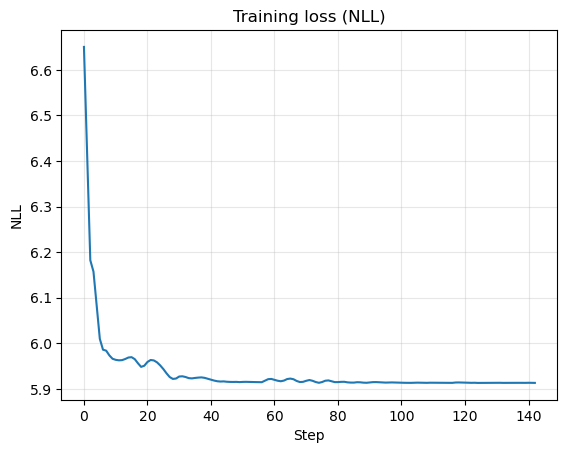

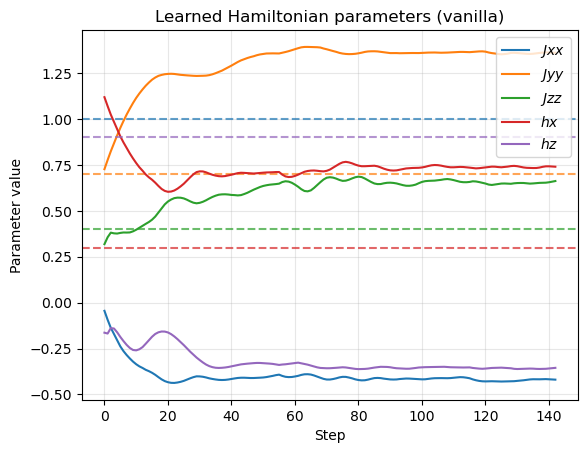

In [ ]:
# 5) Trainning (NLL) — VANILLA (5 parameters) + Early stopping 

def train_vanilla_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    init_params=None,
    patience_stop: int = 30,   
    min_delta: float = 1e-5,  
):
    """
    Train a Hamiltonian learning model using vanilla NLL minimization.
    Minimizes NLL over samples: NLL = - mean_{s,t,p,shot} log p_theta(sample)
    Early stopping: If the NLL does not improve by at least `min_delta` for `patience_stop` iterations,
      training stops early before reaching `num_steps`.
    """
    n = int(dataset["n"])
    times = dataset["times"]                 # (T,) numpy
    pauli_obs = dataset["pauli_obs"]         # (P,n) numpy
    samples = dataset["samples"]             # (S,T,P,shots) numpy
    init_states = dataset["initial_states"]  # (S,2^n) numpy complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # Convert initial states to torch
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # Precompute rotation matrices for each pauli observable row (P of them)
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)

    if init_params is None:
        init_params = [0.5, 0.5, 0.5, 0.5, 0.5]

    params = torch.nn.Parameter(torch.tensor(init_params, dtype=torch.float64, device=device)) # convert to torch parameter
    opt = torch.optim.Adam([params], lr=lr) # optimizer

    loss_hist = [] # to store the NLL values during training
    param_hist = [] # to store the parameter values during training

    # True parameters for plotting
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    # Early stopping variables
    best_nll = float("inf")
    steps_since_improve = 0

    # Training loop
    for step in range(num_steps):
        opt.zero_grad()

        H = build_ansatz_hamiltonian_torch(n, params.to(torch.complex128), device=device) # Build H(params)

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device) # accumulator for log probabilities
        count = 0 # total number of samples (shots) processed

        for s in range(S): # loop over initial states
            psi0 = init_states_t[s]  # initial state for this sample
            for ti in range(T): # loop over time points
                t = float(times[ti]) 
                psi_t = evolve_state_matrix_exp(H, psi0, t) # compute the state at time t

                for p in range(P): # loop over Pauli observables
                    probs = probs_in_measurement_basis(psi_t, Urots[p])  # probabilities for all outcomes in the measurement basis defined by pauli_obs[p]
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device)  # indices of the sampled outcomes 
                    p_samp = probs[idx]  # # probabilities of the sampled outcomes
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps)) # accumulate log probabilities
                    count += shots # accumulate count of samples

        nll = -total_logp / count # average negative log likelihood per sample
        nll.backward() # compute gradients
        opt.step() # update parameters

        nll_val = float(nll.detach().cpu().item()) # get scalar value for logging
        loss_hist.append(nll_val) # store loss history
        param_hist.append(params.detach().cpu().numpy().copy()) # store parameter history

        # Print 
        cur = param_hist[-1]
        print(
            f"Step {step+1:4d}/{num_steps} | NLL={nll_val:.6f} | "
            f"Jxx={cur[0]:.4f} (true {true_vec[0]:.4f}) | "
            f"Jyy={cur[1]:.4f} (true {true_vec[1]:.4f}) | "
            f"Jzz={cur[2]:.4f} (true {true_vec[2]:.4f}) | "
            f"hx={cur[3]:.4f} (true {true_vec[3]:.4f}) | "
            f"hz={cur[4]:.4f} (true {true_vec[4]:.4f})"
        )

        # Early stopping 
        if nll_val < best_nll - min_delta: 
            best_nll = nll_val # update best NLL
            steps_since_improve = 0 # reset counter if we have improvement
        else:
            steps_since_improve += 1 # increment counter if no improvement

        if steps_since_improve >= patience_stop: # check if we should stop
            print(
                f"[EarlyStopping] Parando en step {step+1} porque la NLL no mejora "
                f"(min_delta={min_delta}) en {patience_stop} iteraciones. Best NLL={best_nll:.6f}"
            )
            break

    history = {"loss": np.array(loss_hist),"params": np.array(param_hist),"true": true_vec, "names": param_names,}
    
    return history


def plot_training(history: dict):
    loss = history["loss"]
    params = history["params"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(params.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (NLL)")
    plt.grid(alpha=0.3)
    plt.show()

    # Params (todas las componentes)
    plt.figure()
    steps = np.arange(len(params))
    for k in range(params.shape[1]):
        plt.plot(steps, params[:, k], label=rf"${names[k]}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(), alpha=0.7)
    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (vanilla)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# Training and plot
init_params = np.random.uniform(0.2, 1, size=5)
history = train_vanilla_model(dataset_mismatched, num_steps=500, lr=1e-2, device="cpu", init_params=init_params)
plot_training(history)


## Neural ODE

In [ ]:
# Neural ODE: RK4 integrator for Schrödinger equation
def rk4_step(psi, dt, H):
    # RK4 step WITHOUT renormalizing inside the integrator
    k1 = (-1j) * (H @ psi)
    k2 = (-1j) * (H @ (psi + 0.5 * dt * k1))
    k3 = (-1j) * (H @ (psi + 0.5 * dt * k2))
    k4 = (-1j) * (H @ (psi + dt * k3))
    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return psi_next


def integrate_ode_rk4(psi0, times_torch, H, m=20):
    """
    Integrate from t=0 to each time in times_torch using RK4 with m substeps.
    Normalization is applied only when storing psi(t_k), not inside RK4.
    """
    states = []
    t_prev = 0.0
    psi = psi0

    for t in times_torch:
        t_target = float(t.item())
        dt_big = t_target - t_prev
        dt = dt_big / m

        for _ in range(m):
            psi = rk4_step(psi, dt, H)
            t_prev += dt

        # normalize once per observation time (numerical stability)
        psi = psi / torch.linalg.norm(psi)
        states.append(psi)

    return torch.stack(states, dim=0)  # (T, dim)

# Neural map NN_phi
class CoeffNet(nn.Module):
    def __init__(self, hidden=32, dim_params=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_params, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim_params),
        )
    def forward(self, c):
        return self.net(c)


def plot_training_nde_eff(history: dict):
    loss = history["loss"]
    c_eff = history["c_eff"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(c_eff.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (Neural ODE)")
    plt.grid(alpha=0.3)
    plt.show()

    # Params efectivos
    plt.figure()
    steps = np.arange(len(c_eff))
    for k in range(c_eff.shape[1]):
        plt.plot(steps, c_eff[:, k], label=rf"${names[k]}^{{eff}}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(), alpha=0.7)

    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (effective)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    


## Train NDE

[NDE] Step    1/500 | NLL=6.025329 | Jxx_eff=0.6232 (true 1.0000) | Jyy_eff=0.8908 (true 0.7000) | Jzz_eff=0.2431 (true 0.4000) | hx_eff=0.9026 (true 0.3000) | hz_eff=0.3951 (true 0.9000)
[NDE] Step    2/500 | NLL=5.977416 | Jxx_eff=0.6118 (true 1.0000) | Jyy_eff=0.9016 (true 0.7000) | Jzz_eff=0.2534 (true 0.4000) | hx_eff=0.8894 (true 0.3000) | hz_eff=0.4083 (true 0.9000)
[NDE] Step    3/500 | NLL=5.921833 | Jxx_eff=0.6004 (true 1.0000) | Jyy_eff=0.9127 (true 0.7000) | Jzz_eff=0.2638 (true 0.4000) | hx_eff=0.8769 (true 0.3000) | hz_eff=0.4218 (true 0.9000)
[NDE] Step    4/500 | NLL=5.858289 | Jxx_eff=0.5889 (true 1.0000) | Jyy_eff=0.9244 (true 0.7000) | Jzz_eff=0.2734 (true 0.4000) | hx_eff=0.8642 (true 0.3000) | hz_eff=0.4353 (true 0.9000)
[NDE] Step    5/500 | NLL=5.793638 | Jxx_eff=0.5769 (true 1.0000) | Jyy_eff=0.9366 (true 0.7000) | Jzz_eff=0.2839 (true 0.4000) | hx_eff=0.8514 (true 0.3000) | hz_eff=0.4494 (true 0.9000)
[NDE] Step    6/500 | NLL=5.729332 | Jxx_eff=0.5644 (true 1.

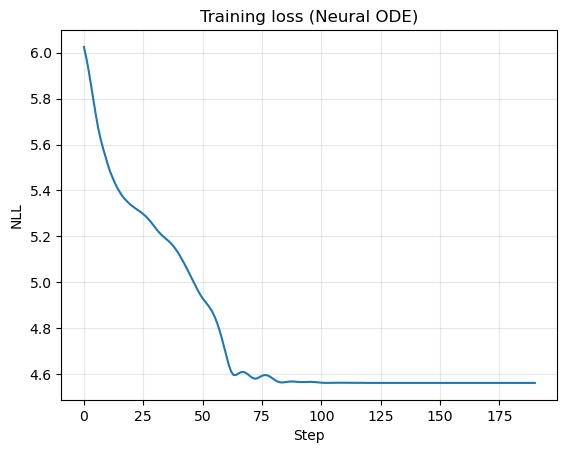

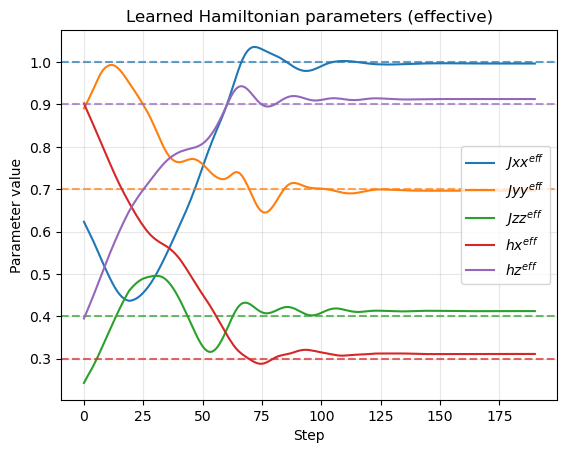

In [ ]:
def train_neural_ode_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    hidden: int = 32,
    dc_scale: float = 0.05,
    m: int = 20,
    regularization: float = 0.001,
    init: list = None,
    patience_stop: int = 50, # early stopping patience
    min_delta: float = 1e-5, # early stopping minimum improvement threshold
):
    """
    Train a Hamiltonian learning model using a Neural ODE approach with RK4 integration.
    The model learns an effective Hamiltonian H_A(c_eff) where c_eff = c + NN_phi(c).
    The loss is the NLL of the samples under the model, plus a regularization term on the NN output (dc).
    Early stopping: If the NLL does not improve by at least `min_delta` for `patience_stop` iterations, training stops early before reaching `num_steps`.
    """
    # load dataset
    n = int(dataset["n"])
    times = torch.tensor(dataset["times"], dtype=torch.float64, device=device)  
    pauli_obs = dataset["pauli_obs"]         
    samples = dataset["samples"]             
    init_states = dataset["initial_states"]  

    S, T, P, shots = samples.shape
    dim = 2**n

    # initial states to torch complex
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # precompute rotation matrices
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)


    dim_params = 5
    if init is None:
        init = [0.5] * dim_params 
    assert len(init) == dim_params, f"`init` debe tener longitud {dim_params}" # check init length

    c = nn.Parameter(torch.tensor(init, dtype=torch.float64, device=device)) # learnable base parameters
    net = CoeffNet(hidden=hidden, dim_params=dim_params).to(device) # neural map for corrections

    opt = torch.optim.Adam(list(net.parameters()) + [c], lr=lr) # optimizer 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, min_lr=1e-4) # scheduler that reduces LR if loss plateaus

    # True parameters
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    loss_hist = [] # to store NLL history
    c_hist = [] # to store base parameter history
    dc_hist = [] # to store NN correction history
    c_eff_hist = [] # to store effective parameter history (c + dc)

    # early stopping
    best_loss = float("inf")
    steps_since_improve = 0

    for step in range(num_steps): # training loop
        opt.zero_grad() # reset gradients

        # NN_phi acts on coefficients
        dc = dc_scale * net(c)    
        c_eff = c + dc             

        H = build_ansatz_hamiltonian_torch(n, c_eff.to(torch.complex128), device=device)# Build H(c_eff)

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device) # accumulator for log probabilities
        count = 0

        for s in range(S): # loop over initial states
            psi0 = init_states_t[s] # initial state for this sample
            psi_ts = integrate_ode_rk4(psi0, times, H, m=m)  # compute psi(t) for all times using RK4 integration

            for ti in range(T): # loop over time points
                psi_t = psi_ts[ti] # state at time t
                for p in range(P): # loop over Pauli observables
                    probs = probs_in_measurement_basis(psi_t, Urots[p]) # probabilities for all outcomes in the measurement basis defined by pauli_obs[p]
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device) # indices of the sampled outcomes
                    p_samp = probs[idx] # probabilities of the sampled outcomes
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps)) # accumulate log probabilities
                    count += shots # accumulate count of samples

        nll = -total_logp / count # average negative log likelihood per sample
        reg = regularization * torch.sum(dc**2) # L2 regularization on the NN correction
        loss = nll + reg    # total loss

        loss.backward() # compute gradients
        opt.step() # update parameters

        # Logging
        loss_val = float(loss.detach().cpu().item())
        loss_hist.append(loss_val)
        c_hist.append(c.detach().cpu().numpy().copy())
        dc_hist.append(dc.detach().cpu().numpy().copy())
        c_eff_hist.append(c_eff.detach().cpu().numpy().copy())

        cur_eff = c_eff_hist[-1] # current effective parameters for logging
        cur_c = c_hist[-1] # current base parameters for logging
        cur_dc = dc_hist[-1] # current NN corrections for logging

        print(
            f"[NDE] Step {step+1:4d}/{num_steps} | NLL={loss_val:.6f} | "
            f"Jxx_eff={cur_eff[0]:.4f} (true {true_vec[0]:.4f}) | "
            f"Jyy_eff={cur_eff[1]:.4f} (true {true_vec[1]:.4f}) | "
            f"Jzz_eff={cur_eff[2]:.4f} (true {true_vec[2]:.4f}) | "
            f"hx_eff={cur_eff[3]:.4f} (true {true_vec[3]:.4f}) | "
            f"hz_eff={cur_eff[4]:.4f} (true {true_vec[4]:.4f})"
        )

        # Scheduler
        scheduler.step(loss.detach())

        # Early stopping
        if loss_val < best_loss - min_delta:
            best_loss = loss_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Parando en step {step+1} porque la loss no mejora "
                f"(min_delta={min_delta}) en {patience_stop} iteraciones. Best={best_loss:.6f}"
            )
            break
    # Return history for plotting
    history = {
        "loss": np.array(loss_hist),
        "c": np.array(c_hist),
        "dc": np.array(dc_hist),
        "c_eff": np.array(c_eff_hist),
        "true": true_vec,
        "names": param_names,
    }
    return history


# Ejecute
init_params = np.random.uniform(0.2, 1, size=5)
history_nde_modificado = train_neural_ode_model(
    dataset_mismatched,
    num_steps=500,
    lr=1e-2,
    hidden=32,
    dc_scale=0.01,
    m=20,
    regularization=0.001,
    init=init_params,
    patience_stop=50,
    min_delta=1e-5
)

plot_training_nde_eff(history_nde_modificado)
